# Environmental Analytics Lecture 10
# Case Study: Floods and Satellite Imagery
B. Schoen-Phelan

31 March 2022

References:
 
1.   [How to Compute Satellite Image Statistics and Use it in Pandas](https://towardsdatascience.com/how-to-compute-satellite-image-statistics-and-use-it-in-pandas-81864a489144)
2.   [Use Data for Earth and Environmental Science in Open Source Python](https://www.earthdatascience.org/courses/use-data-open-source-python/), CU Bolder. 

Rasterio is the package that is used for handling raster data in Python. There are other packages available that also handle raster data, but rasterio is one of the most popular ones.

https://rasterio.readthedocs.io/en/latest/

The package allows you to read and write spatial raster data files. These often come in so called GeoTIFF format, which is the same as the TIFF format, but with a spatial component. More about the GeoTIFF format:
https://www.loc.gov/preservation/digital/formats/fdd/fdd000279.shtml

`GeoTIFF can store a broad range of georeferencing information, catering to geographic as well as projected coordinate systems needs. `


In [1]:
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 16.7 MB 378 kB/s 
     |████████████████████████████████| 6.3 MB 38.9 MB/s 
     |████████████████████████████████| 19.3 MB 1.7 MB/s 


In [2]:
# relevan imports
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt

## Getting the Data

There are several Python APIs to retrieve satellite data. One of the easiest to use APIs is [sentinelsat](https://pypi.org/project/sentinelsat/). Alternatively, there are several download portals that allow manual selection and download of data. These are often non-trivial in their use. Additionally, real satellite image data tends to be very large. It is not uncommon wanting to avoid this. Addressing these concerns resulted in the [Cloud Optimized GeoTiff](https://www.cogeo.org/).

For today's case study, we will use a pre-prepared image data set. 

The Data used as part of this case study has been provided by github user [shakasom](https://github.com/shakasom) and is in the public domain.

This week another notebook is provided in your module on brightspace. This shows how to download and handle unprepared satellite data.

In [3]:
# for students download via gdown
!gdown https://drive.google.com/uc?id=1Js5c663NaQOiiVntB_E3PWtlFx8yyioq

Downloading...
From: https://drive.google.com/uc?id=1Js5c663NaQOiiVntB_E3PWtlFx8yyioq
To: /content/Data.zip
100% 4.16M/4.16M [00:00<00:00, 228MB/s]


In [4]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/20191002/
  inflating: Data/20191002/B02-20191002.tif  
  inflating: Data/20191002/B03-20191002.tif  
  inflating: Data/20191002/B04-20191002.tif  
  inflating: Data/20191002/B08-20191002.tif  
   creating: Data/20191101/
  inflating: Data/20191101/B02-20191101.tif  
  inflating: Data/20191101/B03-20191101.tif  
  inflating: Data/20191101/B04-20191101.tif  
  inflating: Data/20191101/B08-20191101.tif  
   creating: Data/shapefiles/
 extracting: Data/shapefiles/boundary.cpg  
  inflating: Data/shapefiles/boundary.dbf  
  inflating: Data/shapefiles/boundary.prj  
  inflating: Data/shapefiles/boundary.qpj  
  inflating: Data/shapefiles/boundary.shp  
  inflating: Data/shapefiles/boundary.shx  
 extracting: Data/shapefiles/osm_buildings.cpg  
  inflating: Data/shapefiles/osm_buildings.dbf  
  inflating: Data/shapefiles/osm_buildings.prj  
  inflating: Data/shapefiles/osm_buildings.qpj  
  inflating: Data/shapefiles/osm_buildings.shp  

Inspect the folder that appears in your data foler on the left. Colab enforces a maximum life time of all virtual machines running of 12 hours. This means that the data will be gone if you log back on. 

If you want to be able to persistantly access this data independent of others providing it, you need to save it to your own cloud storage, for example google drive. We have done this in previous labs. Abbreviated steps: 

```
from google.colab import drive
drive.mount('/content/gdrive')
```

and and then copy the file to your location via

```
!cp filename location
```

## Loading and Inspecting Satellite Files

Multispectral remote sensing is a passive type of remote sensing. This means that the sensor is measuring light energy from an existing source. In comparison, active remote sensing means that an instrument emits energy actively rather than collecting information about light energy from another source. An example of active remote sensing is [LiDAR (Light Detection and Ranging)](https://oceanservice.noaa.gov/facts/lidar.html#:~:text=Lidar%20%E2%80%94%20Light%20Detection%20and%20Ranging,the%20surface%20of%20the%20Earth.&text=These%20light%20pulses%E2%80%94combined%20with,Earth%20and%20its%20surface%20characteristics.).

In order to understand satellite data, you need to understand the electromagnetic spectrum. To better understand multispectral remote sensing you need to know some basic principles of the electromagnetic spectrum. 
The electromagnetic spectrum is composed of a range of different wavelengths of light energy. A spectral remote sensing instrument collects light energy within specific regions of the electromagnetic spectrum. Each region in the spectrum is referred to as a band. To understand the electromagnetic spectrum deeper, please see this youtube Tutorial [Mapping The Invisible: Introduction to Spectral Remote Sensing](https://www.youtube.com/watch?v=3iaFzafWJQE). Last week's lecture slides presented an overview of the sentinel-2 spectral bands.

Satellite data provides bands in different spectral and spatial resolutions.
*   Spectral Resolution: The spectral resolution of a dataset that has more than one band refers to the spectral width of each band in the dataset. To see an example of this, check out the band widths for the different satellite  sensors. While a general spectral resolution of the sensor is often provided, not all sensors collect information within bands of uniform widths.
*  Spatial Resolution: The spatial resolution of a raster represents the area on the ground that each pixel covers. If you have smaller pixels in a raster the data will appear more *detailed*. If you have large pixels in a raster, the data will appear more coarse or *fuzzy*. Consequently, higher resolution data shows you more detail of an area, but comes at the cost of larger storage needed.


Depending on how you access satellite imagery, the bands are going to be presented either in separate files, or in one file with multiple layers. You can also manipulate or convert these using `rasterio` or `rioxarray`, or similar Python modules.

The following case study provides the bands individually in tif files. Read more about the [GeoTiff file format here](https://www.gislounge.com/what-is-a-geotiff/).

This process of deriving table outputs (Summary statistics) from raster images is called **Zonal Statistics**.

#### Loading Data with rasterio

In [5]:
# The data provided here describes an area in
# in Beledweyne, Somalia, on 1 November 2019 
b8 = rio.open("/content/Data/20191101/B08-20191101.tif") #NIR
b4 = rio.open("/content/Data/20191101/B04-20191101.tif") #Red
b3 = rio.open("/content/Data/20191101/B03-20191101.tif") #Green
b2 = rio.open("/content/Data/20191101/B02-20191101.tif") #Blue

####Inspecting Data Properties

In [6]:
# .count gives the amount of bands available in this tif file
# here 1
# width tells us about how many pixels are in this file
# for managability the files for this case study presentation
# have been sampled down. If you download real satellite data
# these are significantly larger.

b4.count, b4.width, b4.height

(1, 479, 429)

In [7]:
# compare to another band
# the outputs are the same

b8.count, b8.width, b8.height

(1, 479, 429)

In [8]:
b4.crs

CRS.from_epsg(32638)

Check out [where that is](http://epsg.io/32638).

####Visualising Satellite Bands

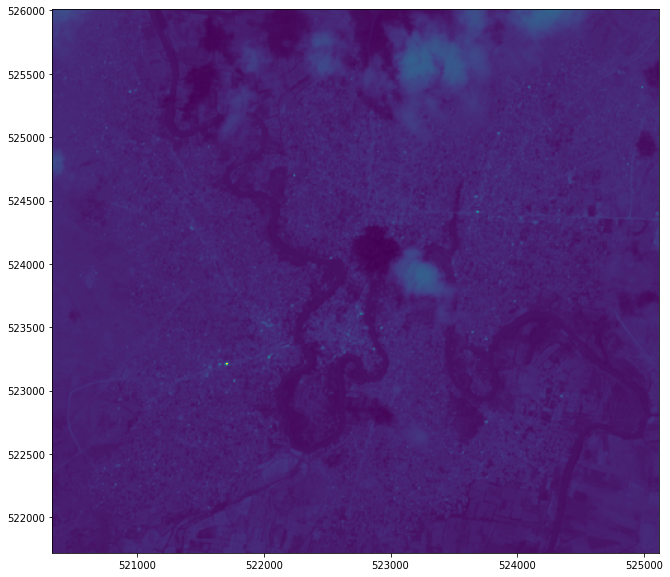

In [9]:
# let's have a look at one of them
# band3 is the green channel
# observe the image
fig, ax = plt.subplots(1, figsize=(12, 10))
show(b3, ax=ax)
plt.show()

Text(0.5, 1.0, 'Blue')

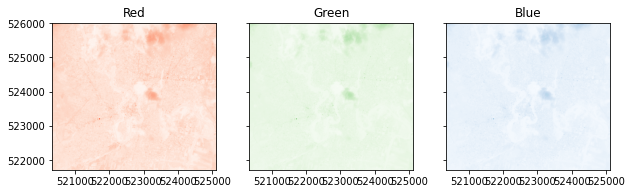

In [10]:
# display the different layers side by side
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((b4, 1), cmap='Reds', ax=ax1)
show((b3, 1), cmap='Greens', ax=ax2)
show((b2, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

Observe how the different colour bands reflect or absorb colour differently. What is dark in which channel? What is lighter?

The image is not very telling, you can just about make out darker or lighter spots. Try the other bands! How is the information different or the same?

A **common** application for public distribution of satellite information is to provide a true **colour composite** of satellite data. This is mostly used for purposes such as presenting satellite data to the public. Here the 3 RGB channels are combined and displayed. We can do this using rasterio:

In [11]:
# Create an RGB image 
# the order in which it is loaded matters
with rio.open('True_Colour_Composite.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),3) # Blue channel is b2
    rgb.write(b3.read(1),2) # Green channel is b3
    rgb.write(b4.read(1),1) # Red channel is b4
    rgb.close()

If you now open this tff file using rasterio and try to plot it like we have done before, you will find that this cannot be done.
However, if you download the file and open it in a program like QGIS it will open fine and you can see the satellite image as if it had been taken by a normal visual camera.

In [12]:
true_cc = rio.open("/content/True_Colour_Composite.tiff") #RGB artifically stacked

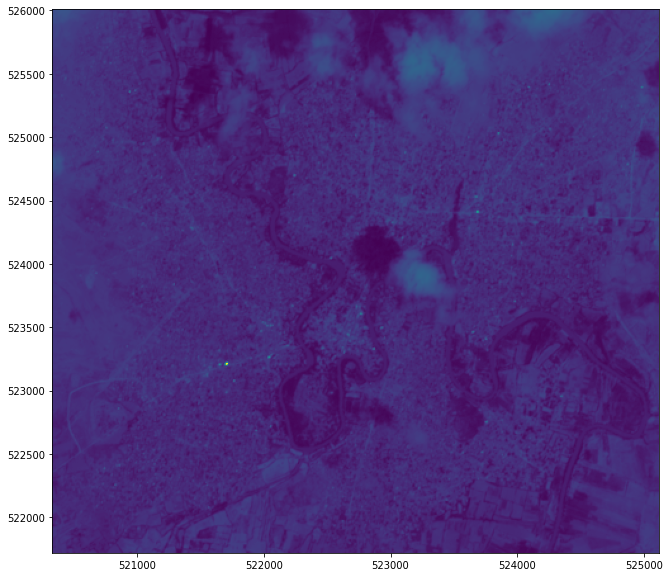

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(true_cc, ax=ax)
plt.show()

Naturally, you would like to visualise the true colour composite that we have created. Visualising raster layers is not a straight forward process. You can download the tiff file and it will display fine in a program like QGIS.

For more on visualising raster layers in one image, see [this course on Python GIS, chapter visualising raster layers](https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html).

The following code demonstrates how it can be achieved in Python itself using [numpy](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html):

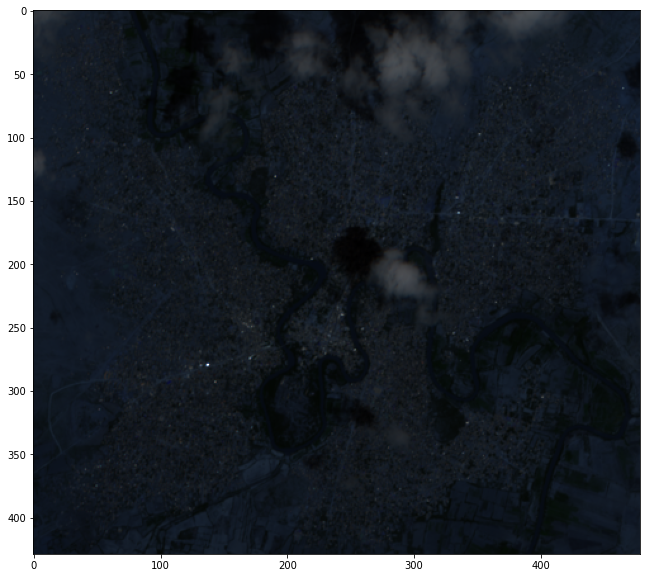

In [14]:
# Open the file:
raster = rio.open('/content/True_Colour_Composite.tiff')

# Normalise bands into 0.0 - 1.0 scale
# this is done for the plotting of the image
def normalise(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
# the order is from the tiff we created earlier
# the SAME can be achieved by reading the original separate channels
# in that case you need to read the first one for each, so for
# example: blue = b2.read(1)
blue = raster.read(3)
green = raster.read(2)
red = raster.read(1)

# Normalise band DN (this is done for the plotting in Python so that matlap can
# read the colour range correctly)
blue_norm = normalise(blue)
green_norm = normalise(green)
red_norm = normalise(red)

# Stack bands
rgb_cc = np.dstack((blue_norm, green_norm, red_norm))

# View the colour composite
plt.figure(figsize = (12,10))
plt.imshow(rgb_cc)


In [15]:
# let's also have a look at these new image values
print("Normalised bands:")
print(red_norm.min(), '-', red_norm.max(), 'mean:', red_norm.mean())
print(green_norm.min(), '-', green_norm.max(), 'mean:', green_norm.mean())
print(blue_norm.min(), '-', blue_norm.max(), 'mean:', blue_norm.mean())

Normalised bands:
0.0 - 1.0 mean: 0.12188212994787223
0.0 - 1.0 mean: 0.0935281816380558
0.0 - 1.0 mean: 0.06934177372865932


There are also so called **False Colour Composites**. Here we **replace** one of the visual light channels with another one. A **common** application is to use the NIR band instead of blue. This is done to detect vegetation more easily, where red colour is emphasised. Let’s use the same raster file as input, and generate our first false colour composite:

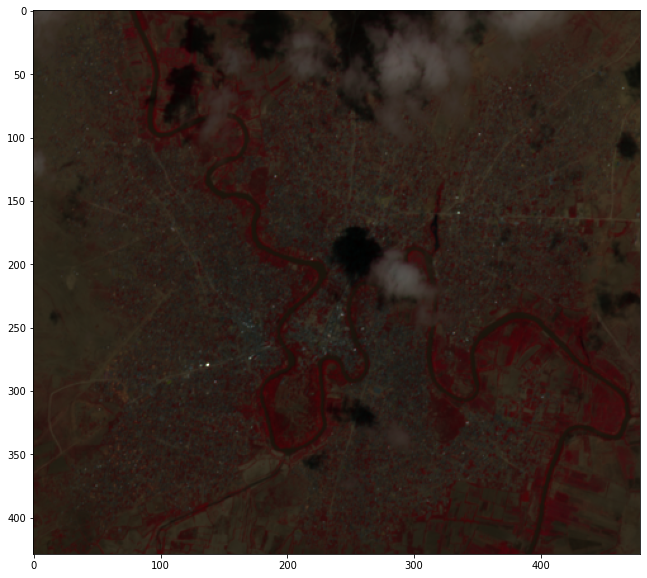

In [16]:
# this is the same principle as before:
# Read the grid values into numpy arrays
nir = b8.read(1)
red = b4.read(1)
green = b3.read(1)

# Normalise the values using the function that we defined earlier
nir_norm = normalise(nir)
red_norm = normalise(red)
green_norm = normalise(green)

# Create the composite by stacking
nrg = np.dstack((nir_norm, red_norm, green_norm))

# Let's see how our false colour composite looks like
plt.figure(figsize = (12,10))
plt.imshow(nrg)

We can see lots of vegetation near the river.

###Mixing in Other Data Sources

In [17]:
# get buildings data
# this data is from OpenStreetMap for this location
buildings = gpd.read_file("/content/Data/shapefiles/osm_buildings.shp")
buildings = buildings[["osm_id","building", "geometry"]]
buildings.head()

osm_id building                                           geometry
0  8275560      yes  POLYGON ((521839.828 524323.388, 521837.607 52...
1  8276697      yes  POLYGON ((522700.756 523641.273, 522727.020 52...
2  8280395      yes  POLYGON ((523000.403 523492.953, 523003.418 52...
3     None      yes  POLYGON ((521087.015 523190.338, 521095.931 52...
4     None      yes  POLYGON ((521096.268 523212.801, 521104.110 52...

You have worked with OSM data before, see previous labs. The output should be familiar.

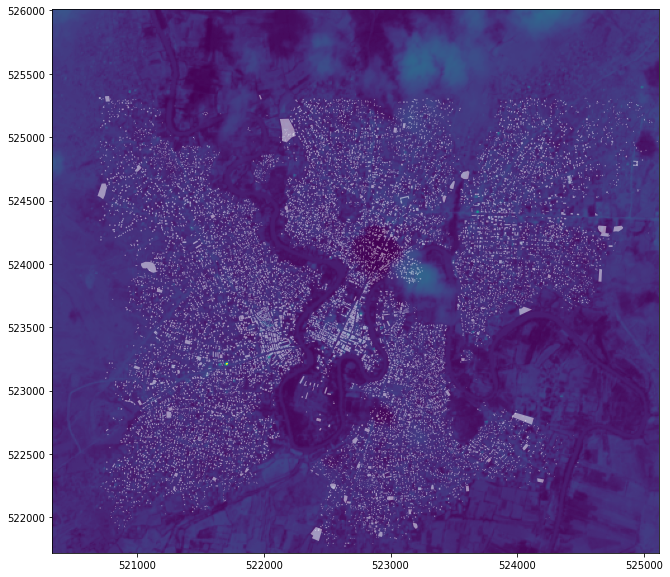

In [18]:
# Let's overlay the information
fig, ax = plt.subplots(figsize=(12, 10))
show(b4, ax=ax) #b4 is the red band
buildings.plot(ax=ax, color="white", alpha=.50)
plt.show();

## Calculate NDWI
NDWI and its purpose and usage has been discussed in last week's lecture slides

Formula: (Band3 — Band8)/(Band3 + Band8)

In [19]:
green = b3.read(1)
nir = b8.read(1)
ndwi = (nir.astype(float)-green.astype(float))/(nir+green)

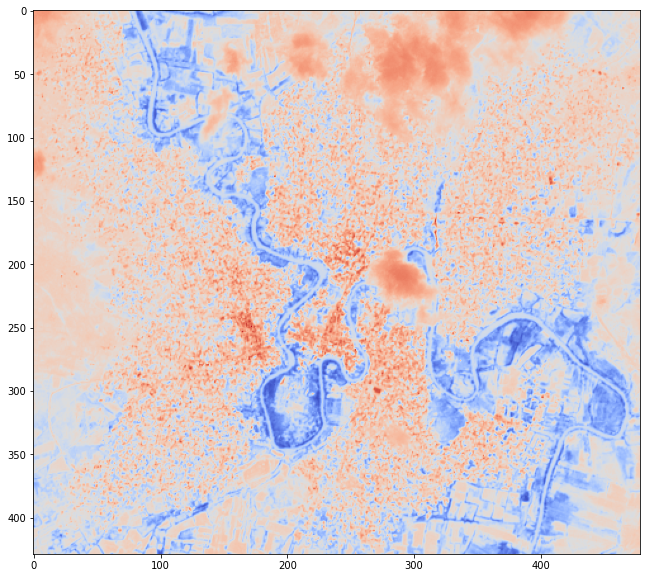

In [20]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(ndwi, ax=ax, cmap="coolwarm_r")
plt.show()

The NDWI plot clearly shows innundated areas near the Shabelle river (Blue). And the extent of flooding goes to residential areas.

We can save the NDWI arrays as a raster image so that we can use it later.


In [21]:
meta = b4.meta
meta

{'count': 1,
 'crs': CRS.from_epsg(32638),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 429,
 'nodata': None,
 'transform': Affine(10.0, 0.0, 520330.0,
       0.0, -10.0, 526010.0),
 'width': 479}

In [22]:
# meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
meta



{'count': 1,
 'crs': CRS.from_epsg(32638),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 429,
 'nodata': None,
 'transform': Affine(10.0, 0.0, 520330.0,
       0.0, -10.0, 526010.0),
 'width': 479}

In [23]:
with rio.open('NDWI.tif', 'w', **meta) as dst:
    dst.write(ndwi.astype(rio.float32), indexes=1)

Now, that we have calculated the NDWI values, it is time to derive statistics from the NDWI raster image and merge to our buildings table. We use the `rasterio mask` functionality to get the cell values from the NDWI raster image.
The following is a small function that masks the cell values to our data frame table.

In [24]:
ndwi_raster = rio.open("NDWI.tif")


In [25]:
masked, mask_transform = mask(dataset=ndwi_raster, 
                              shapes=buildings.geometry, crop=True)

In [26]:
masked

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.08934842, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [27]:
masked.mean()

0.013454553

In [28]:
masked.max()

0.57300335

In [29]:
ndwi_raster.crs

CRS.from_epsg(32638)

In [30]:
b4.crs

CRS.from_epsg(32638)

In [31]:
buildings.crs

<Projected CRS: EPSG:32638>
Name: WGS 84 / UTM zone 38N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 42°E and 48°E, northern hemisphere between equator and 84°N, onshore and offshore. Armenia. Azerbaijan. Djibouti. Eritrea. Ethiopia. Georgia. Islamic Republic of Iran. Iraq. kazakhstan. Kuwait. Russian Federation. Saudi Arabia. Somalia. Turkey. Yemen.
- bounds: (42.0, 0.0, 48.0, 84.0)
Coordinate Operation:
- name: UTM zone 38N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
buildings = buildings.to_crs(ndwi_raster.crs)


We have calculated the NDWI values. It is time to derive statistics from the NDWI raster image and merge this information back to our buildings table. We use the  `rasterio`  mask functionality to get the cell values from the NDWI raster image.
The following is a small function that masks the cell values to our data frame table:

In [33]:
def derive_stats(geom, data=ndwi_raster, **mask_kw):
    masked, mask_transform = mask(dataset=data, shapes=(geom,),
                                  crop=True, all_touched=True, filled=True)
    return masked

In [34]:
buildings['mean_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.mean)


In [35]:
buildings['max_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.max)


In [36]:
buildings.head()

osm_id building                                           geometry  \
0  8275560      yes  POLYGON ((521839.828 524323.388, 521837.607 52...   
1  8276697      yes  POLYGON ((522700.756 523641.273, 522727.020 52...   
2  8280395      yes  POLYGON ((523000.403 523492.953, 523003.418 52...   
3     None      yes  POLYGON ((521087.015 523190.338, 521095.931 52...   
4     None      yes  POLYGON ((521096.268 523212.801, 521104.110 52...   

   mean_ndwi  max_ndwi  
0   0.207663  0.263993  
1   0.066127  0.255757  
2   0.067684  0.247811  
3   0.186061  0.268627  
4   0.187913  0.265823

Let's do some more plotting with this new information.

In [37]:
!pip install mapclassify

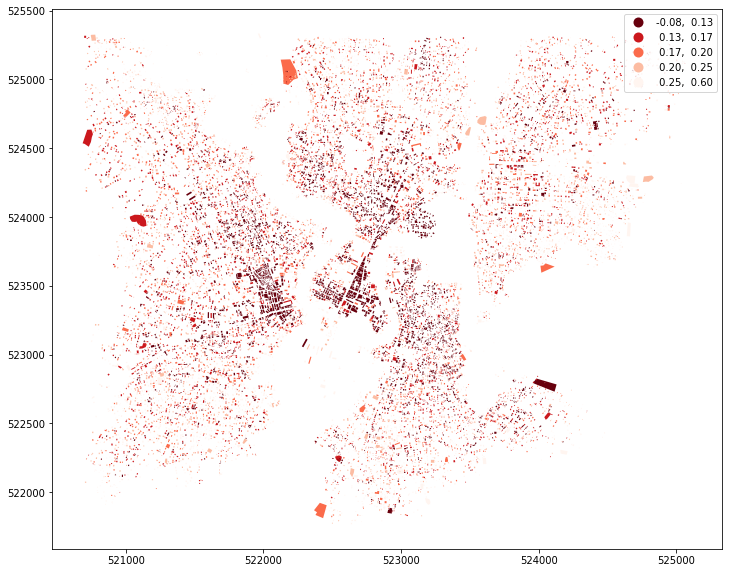

In [38]:
fig, ax = plt.subplots(figsize=(12,10))
buildings.plot(column="mean_ndwi", ax=ax, cmap="Reds_r", scheme='quantiles', legend=True)

In [39]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


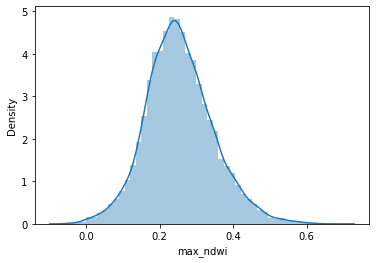

In [40]:
sns.distplot(buildings.max_ndwi)


Let's plot those buildings with high ndwi values. See lecture slides for the meaning of value ranges of NDWI.

As a brief reminder:
*   smaller 0.3: non-water
*   greater equal 0.3: water

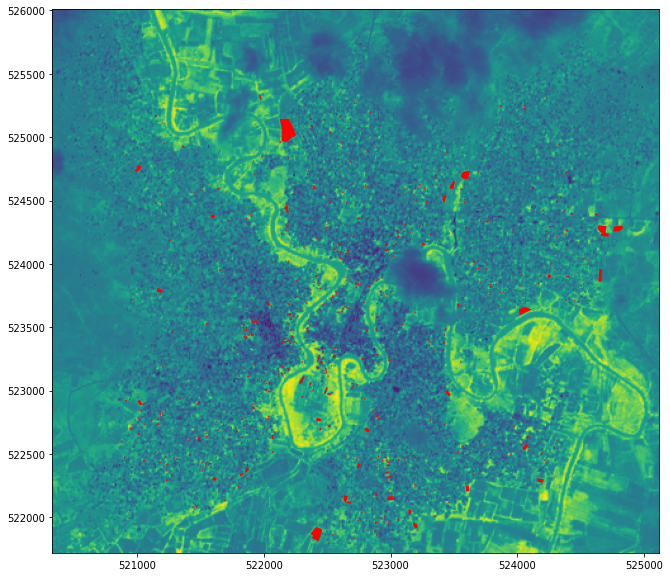

In [41]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0.4, 0.6)].plot(color="red", ax=ax)
plt.show();

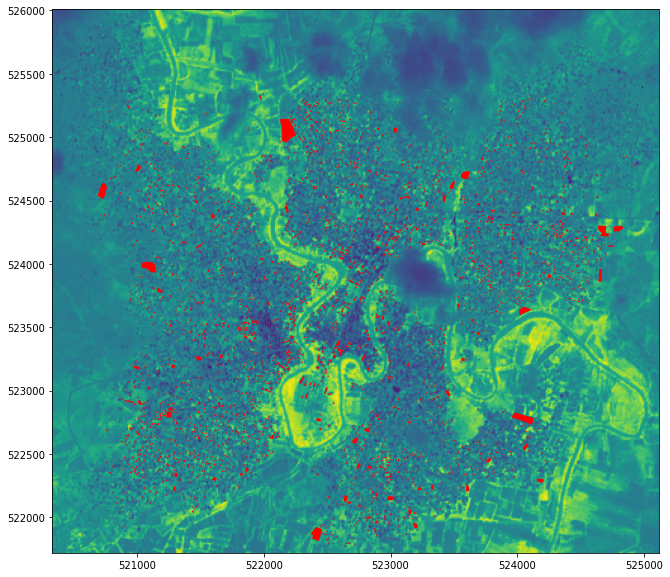

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
# buildings[buildings["max_ndwi"].between(0.4, 0.6)].plot(color="red", ax=ax)
buildings[buildings["max_ndwi"] > 0.3].plot(color="red", ax=ax)
plt.show()

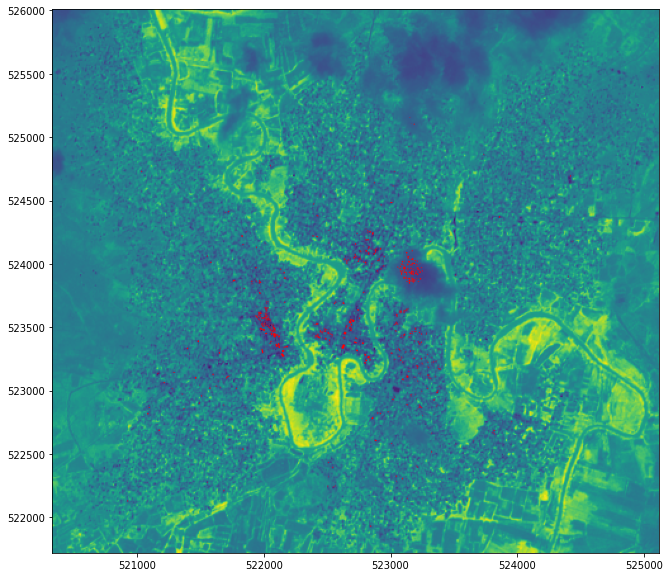

In [43]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0, 0.1)].plot(color="red", ax=ax)
plt.show();

The dataset also includes Sentinel images from previous dates, aka before the flood event in this area. In the “Data” folder, you see a `20191002` folder. 

##Task
Try to calculate the mean and max NDWI values using these images. Compare this with statistics derived from images we have calculated for the date 20191101 (aka, the flooding period).

##Additional Material to study
[Why a 100 year flood can occur every year](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/floods-return-period-and-probability/)